In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from functions import winsor, sPCAest, corr_uniform
from scipy.ndimage import shift
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, FastICA
from sklearn.preprocessing import StandardScaler

# Weak factor case

In [7]:
def generate_data(n, T, N, h_steps=1, heteroskedastic=False, psi_max=None, rho=None):
    # Check if weak or strong factor model
    if n == N:
        # Strong factor model, require psi_max and rho
        assert psi_max is not None
        assert rho is not None

    # Generate y_{t + h} = g_t + e_{t + h}
    # e_{t + h} ~ N(0, 1)
    # g_t ~ N(0, 1)
    # X_t,i = g_t*phi_i + h_t*psi_i + u_t,i

    # Set T to T + h to account for lag
    T_plus_h = T + h_steps

    # Generate g_t
    g = np.random.normal(0, 1, T_plus_h)

    # Generate h_t
    h = np.random.normal(0, 1, T_plus_h)
    
    # Generate e_t+h
    e = np.random.normal(0, 1, T_plus_h)

    # Generate y_{t+h}
    y_h = g + e

    # Generate y_t
    y_t = np.zeros(T_plus_h)
    for i in range(h_steps, T_plus_h):
        y_t[i] = y_h[i - h_steps]

    phi = np.zeros(N)
    psi = np.zeros(N)

    if n < N:
        # Generate phi_i (Nx1) with n < N nonzero elements
        phi[:n] = np.random.uniform(0, 1, n)

        # Generate psi_i (Nx1) with n < N nonzero elements
        psi[:n] = np.random.uniform(0, 1, n)

        # Generate idiosyncratic error's variances
        variance_u = np.random.uniform(0, 1, N)        
    elif n == N:
        # Phi is U(0, phi_max)
        psi = np.random.uniform(0, psi_max, N)

        # Draw correlated phi and sigma_u
        # Generate correlation matrix for phi and sigma_u
        phi, variance_u = corr_uniform(rho=rho*1.1, size=N)

    u = np.zeros((T, N))
    # Generate u_t,i depending on whether the model is heteroskedastic or not
    if heteroskedastic:
        for t in range(T):
            scale = np.random.uniform(0.5, 1.5)
            u[t, :] = np.random.normal(0, variance_u * scale, N)
    else:
        # Generate covariance matrix for u_t
        sigma_u = np.diag(variance_u)

        # Generate u
        u = np.random.multivariate_normal(np.zeros(N), sigma_u, T)

    # Drop first h rows
    y_h = y_h[h_steps:]
    y_t = y_t[h_steps:]
    e = e[h_steps:]
    g = g[h_steps:]
    h = h[h_steps:]

    # Generate X_t
    X = np.zeros((T, N))
    for i in range(N):
        X[:, i] = g*phi[i] + h*psi[i] + u[:, i]

    X_alt = g[:, np.newaxis]*phi[np.newaxis, :] + h[:, np.newaxis]*psi[np.newaxis, :] + u


    print(X == X_alt)

    results = {'y_t':y_t,
               'y_h':y_h,
                'X':X,
                'g':g,
                'e':e,
                }
    
    return results

# Testing
results = generate_data(10, T=250, N=500, h_steps=1)
y_t = results['y_t']
y_h = results['y_h']
X = results['X']
e = results['e']
g = results['g']

print(y_t.shape)
print(y_h.shape)
print(X.shape)

print('y_t: ', y_t[:10])
print('y_h: ', y_h[:10])
print()
print('e: ', e[:10])
print('g: ', g[:10])


[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
(250,)
(250,)
(250, 500)
y_t:  [-2.73734973  1.8630474   2.39120955 -0.62160641  0.17073654  1.55574601
  0.75892729  0.60428178 -1.12279542  2.2575712 ]
y_h:  [ 1.8630474   2.39120955 -0.62160641  0.17073654  1.55574601  0.75892729
  0.60428178 -1.12279542  2.2575712   0.20561965]

e:  [ 0.62944735  0.49903383  0.11734975 -0.09270302  0.45693108 -0.23932239
  0.29842585 -1.319057    1.00532344 -1.52209293]
g:  [ 1.23360005  1.89217571 -0.73895616  0.26343956  1.09881493  0.99824969
  0.30585593  0.19626158  1.25224776  1.72771258]


In [3]:
def simulate_PCA(n=10, T=250, N=500, h_steps=1, R=10, nfac=2, method="sPCA", heteroskedastic=False, psi_max=None, rho=None):
    # Initialize the MSE vector
    predicted = np.zeros((R, 50 - h_steps - 1))
    error_mat = np.zeros((R, 50 - h_steps - 1))

    for r in range(R):
        variables = generate_data(n=n, T=T, h_steps=h_steps, N=N, heteroskedastic=heteroskedastic, psi_max=psi_max, rho=rho)

        # y_t contains the values of y at time t, and y_h contains the values of y at time t+h
        # X contains the values of X at time t
        y_h = variables['y_h']
        y_t = variables['y_t']
        X = variables['X']
        
        # Loop for expanding window estimation
        # The initial window size is 200 observations
        # The window size is increased by 1 observation at each iteration
        # The window size is increased until it reaches 250 observations

        for t in range(50 - h_steps - 1):
            if t % 10 == 0:
                print("Run {} Period {}".format(r, t))

            # Split data into training and testing sets
            # Training set is the first 200 + t observations
            # Testing set is the last 50 - t observations
            idx_split = 200 + t
            
            X_train = X[:idx_split]
            y_train = y_h[:idx_split]
            y_test = y_t[idx_split]

            if method == "sPCA":
                # Estimate the parameters of the model using sPCAest
                # The function sPCAest is defined in functions.py
                factors, _ = sPCAest(target=y_train, X=X_train, nfac=nfac)
            elif method == "PCA":
                pca = PCA(n_components=nfac)
                X_normalized = StandardScaler(with_mean=True, with_std=True).fit_transform(X_train)
                pca.fit(X_normalized)
                factors = pca.transform(X_normalized)
                
            reg = LinearRegression().fit(factors[:-h_steps,:], y_train[:-h_steps])

            # Predict y_{t+h} using the estimated parameters
            y_pred = reg.predict(factors[-1].reshape(1, -1))

            # Add predicted value to the predicted vector
            predicted[r, t] = y_pred
            
            # Compute the error
            error_mat[r, t] = y_pred - y_test
            
    return error_mat, predicted

In [4]:
# Run the simulationc:\Users\Vincent\Anaconda3New\envs\thesis\lib\site-packages\sklearn\decomposition\_fastica.py:729
errors, predictions = simulate_PCA(n=50, T=250, N=500, h_steps=1, R=10, nfac=2, method="sPCA", heteroskedastic=False)

Run 0 Period 0
Run 0 Period 10
Run 0 Period 20
Run 0 Period 30
Run 0 Period 40
Run 1 Period 0
Run 1 Period 10
Run 1 Period 20
Run 1 Period 30
Run 1 Period 40
Run 2 Period 0
Run 2 Period 10
Run 2 Period 20
Run 2 Period 30
Run 2 Period 40
Run 3 Period 0
Run 3 Period 10
Run 3 Period 20
Run 3 Period 30
Run 3 Period 40
Run 4 Period 0
Run 4 Period 10
Run 4 Period 20
Run 4 Period 30
Run 4 Period 40
Run 5 Period 0
Run 5 Period 10
Run 5 Period 20
Run 5 Period 30
Run 5 Period 40
Run 6 Period 0
Run 6 Period 10
Run 6 Period 20
Run 6 Period 30
Run 6 Period 40
Run 7 Period 0
Run 7 Period 10
Run 7 Period 20
Run 7 Period 30
Run 7 Period 40
Run 8 Period 0
Run 8 Period 10
Run 8 Period 20
Run 8 Period 30
Run 8 Period 40
Run 9 Period 0
Run 9 Period 10
Run 9 Period 20
Run 9 Period 30
Run 9 Period 40


In [5]:
mse_vec = (errors**2).mean(axis=1)
median_mse = np.median(mse_vec)
mean_mse = mse_vec.mean()
print("Median MSE is {}".format(median_mse))
print("Mean MSE is {}".format(mean_mse))
print("MSE is {}".format(mse_vec))

Median MSE is 1.0259782856566304
Mean MSE is 1.0635254975978603
MSE is [0.98697181 0.85865456 1.28381109 0.73441105 1.22908107 0.91545572
 1.22883804 1.06498476 1.41960414 0.91344274]


## Plotting

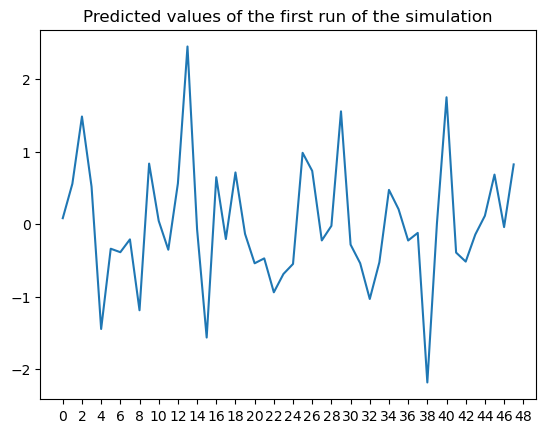

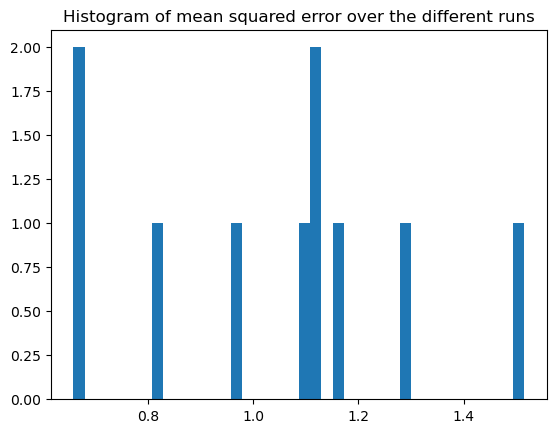

In [11]:
# Plot erros of the first run of the simulation
plt.plot((predictions[0,:]))
plt.title("Predicted values of the first run of the simulation")
# Include tick at every other integer
plt.xticks(np.arange(0, 50, 2))
plt.show()

# Plot the histogram of  mean squared error over the different runs
plt.hist(mse_vec, bins=40)
plt.title("Histogram of mean squared error over the different runs")
plt.show()
